<a href="https://colab.research.google.com/github/nikitazhuikov/ML-projects/blob/main/TitanikSklearnML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [67]:
titanic_df = pd.read_csv('Titanic-Dataset.csv', usecols=['Pclass', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

In [68]:
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,34.5,0,0,7.8292,Q
1,1,3,female,47.0,1,0,7.0000,S
2,0,2,male,62.0,0,0,9.6875,Q
3,0,3,male,27.0,0,0,8.6625,S
4,1,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...
413,0,3,male,NaN,0,0,8.0500,S
414,1,1,female,39.0,0,0,108.9000,C
415,0,3,male,38.5,0,0,7.2500,S
416,0,3,male,NaN,0,0,8.0500,S


In [69]:
titanic_df['Sex'] = pd.factorize(titanic_df['Sex'])[0]

In [70]:
titanic_df['Embarked'] = pd.factorize(titanic_df['Embarked'])[0]

In [71]:
titanic_df = titanic_df.dropna()

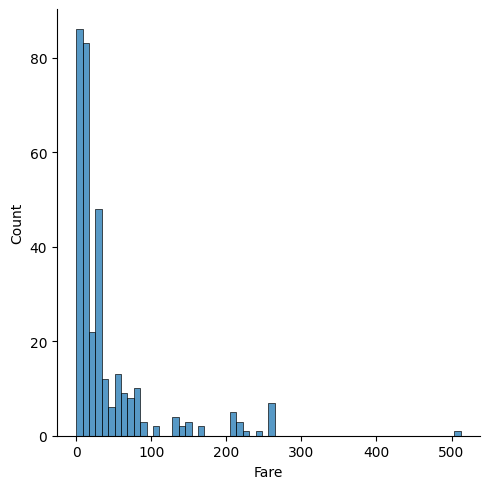

In [72]:
sns.displot(titanic_df, x='Fare', bins=60)

In [73]:
max(titanic_df['Fare'])

512.3292

<Axes: xlabel='Fare'>

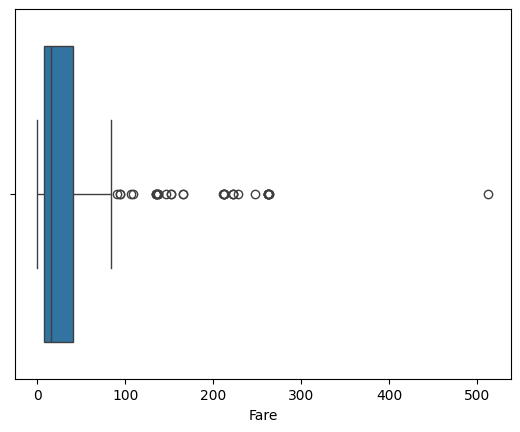

In [74]:
sns.boxplot(x=titanic_df['Fare'])

In [75]:
titanic_df[titanic_df['Fare'] > 200].shape

(18, 8)

In [76]:
# нормализация
titanic_df['Fare_scaled_standart'] = StandardScaler().fit_transform(titanic_df[['Fare']])

<ipython-input-76-54b7eec55908>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Fare_scaled_standart'] = StandardScaler().fit_transform(titanic_df[['Fare']])


In [77]:
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_scaled_standart
0,0,3,0,34.5,0,0,7.8292,0,-0.542281
1,1,3,1,47.0,1,0,7.0000,1,-0.555844
2,0,2,0,62.0,0,0,9.6875,0,-0.511885
3,0,3,0,27.0,0,0,8.6625,1,-0.528651
4,1,3,1,22.0,1,1,12.2875,1,-0.469357
...,...,...,...,...,...,...,...,...,...
409,1,3,1,3.0,1,1,13.7750,1,-0.445026
411,1,1,1,37.0,1,0,90.0000,0,0.801785
412,1,3,1,28.0,0,0,7.7750,1,-0.543168
414,1,1,1,39.0,0,0,108.9000,2,1.110932


In [78]:
x = titanic_df.drop('Survived', axis = 1)

In [79]:
y = titanic_df['Survived']

In [81]:
x = titanic_df.drop('Fare', axis = 1)

In [88]:
x_train, x_test, y_train,  y_test = train_test_split(x, y, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

In [89]:
mdl = LogisticRegression(max_iter=500)

In [90]:
mdl.fit(x_train, y_train)

LogisticRegression(max_iter=500)

In [114]:
y_pred = mdl.predict(x_val)

In [115]:
predictions_df = pd.DataFrame({'Predicted_Survived': y_pred}, index=x_val.index)
df_merged = x_val.merge(predictions_df, left_index=True, right_index=True, how='left')

In [118]:
TP = len(df_merged[(df_merged['Survived'] == 1) & (df_merged['Predicted_Survived'] == 1)])
TN = len(df_merged[(df_merged['Survived'] == 0) & (df_merged['Predicted_Survived'] == 0)])
FP = len(df_merged[(df_merged['Survived'] == 0) & (df_merged['Predicted_Survived'] == 1)])
FN = len(df_merged[(df_merged['Survived'] == 1) & (df_merged['Predicted_Survived'] == 0)])

In [120]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP  / (TP + FP)
recall = TP / (TP + FP)
sensitivity = TP / (TP + FN)

In [122]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('sensitivity:', sensitivity)

accuracy: 1.0
precision: 1.0
recall: 1.0
sensitivity: 1.0


In [94]:
mdl.predict(x_val)

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0])

In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5001")

In [ ]:
with mlflow.start_run(run_name="my_model_run"):
    # Log model parameters (optional but recommended)
    mlflow.log_param("penalty", mdl.penalty)
    mlflow.log_param("C", mdl.C)
    mlflow.sklearn.log_model(mdl, "mdl")

2025/04/01 21:52:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run my_model_run at: http://127.0.0.1:5001/#/experiments/0/runs/b195e03545974e09a584facadaafc64f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/0


In [ ]:
result = mlflow.register_model(
    "runs:/d16076a3ec534311817565e6527539c0/sklearn-model", "mdl"
)

In [ ]:
sex_index = StringIndexer(inputCol='Sex', outputCol="Sex_index")
embarked_index = StringIndexer(inputCol='Embarked', outputCol="Embarked_index")

In [ ]:
titanic_df = sex_index.fit(titanic_df).transform(titanic_df)

In [ ]:
titanic_df = embarked_index.fit(titanic_df).transform(titanic_df)

In [ ]:
titanic_df.show()

+--------+------+------+----+-----+-----+-------+--------+-----------+-----+---------+--------------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Family_Size|Alone|Sex_index|Embarked_index|
+--------+------+------+----+-----+-----+-------+--------+-----------+-----+---------+--------------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|          1|    0|      0.0|           0.0|
|       1|     1|female|38.0|    1|    0|71.2833|       C|          1|    0|      1.0|           1.0|
|       1|     3|female|26.0|    0|    0|  7.925|       S|          0|    1|      1.0|           0.0|
|       1|     1|female|35.0|    1|    0|   53.1|       S|          1|    0|      1.0|           0.0|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|          0|    1|      0.0|           0.0|
|       0|     3|  male|30.0|    0|    0| 8.4583|       Q|          0|    1|      0.0|           2.0|
|       0|     1|  male|54.0|    0|    0|51.8625|       S|          0|    1|      

In [ ]:
features = ['Pclass', 'Age', 'SibSp', 'SibSp', 'Parch', 'Fare', 'Alone', 'Sex_index', 'Embarked_index']

In [ ]:
feature = VectorAssembler(inputCols=features, outputCol="features")
feature_vector= feature.transform(titanic_df)

In [ ]:
feature_vector.show(5)

+--------+------+------+----+-----+-----+-------+--------+-----------+-----+---------+--------------+--------------------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Family_Size|Alone|Sex_index|Embarked_index|            features|
+--------+------+------+----+-----+-----+-------+--------+-----------+-----+---------+--------------+--------------------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|          1|    0|      0.0|           0.0|[3.0,22.0,1.0,1.0...|
|       1|     1|female|38.0|    1|    0|71.2833|       C|          1|    0|      1.0|           1.0|[1.0,38.0,1.0,1.0...|
|       1|     3|female|26.0|    0|    0|  7.925|       S|          0|    1|      1.0|           0.0|[3.0,26.0,0.0,0.0...|
|       1|     1|female|35.0|    1|    0|   53.1|       S|          1|    0|      1.0|           0.0|[1.0,35.0,1.0,1.0...|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|          0|    1|      0.0|           0.0|(9,[0,1,5,6],[3.0...|
+--------+------

In [ ]:
(training_data, test_data) = feature_vector.randomSplit([0.8, 0.2],seed = 42)

In [ ]:
training_data.show(5)

+--------+------+------+----+-----+-----+------+--------+-----------+-----+---------+--------------+--------------------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|  Fare|Embarked|Family_Size|Alone|Sex_index|Embarked_index|            features|
+--------+------+------+----+-----+-----+------+--------+-----------+-----+---------+--------------+--------------------+
|       0|     1|female| 2.0|    1|    2|151.55|       S|          3|    0|      1.0|           0.0|[1.0,2.0,1.0,1.0,...|
|       0|     1|female|25.0|    1|    2|151.55|       S|          3|    0|      1.0|           0.0|[1.0,25.0,1.0,1.0...|
|       0|     1|  male|18.0|    1|    0| 108.9|       C|          1|    0|      0.0|           1.0|[1.0,18.0,1.0,1.0...|
|       0|     1|  male|19.0|    1|    0|  53.1|       S|          1|    0|      0.0|           0.0|[1.0,19.0,1.0,1.0...|
|       0|     1|  male|19.0|    3|    2| 263.0|       S|          5|    0|      0.0|           0.0|[1.0,19.0,3.0,3.0...|
+--------+------+------+

# ML models

# LogisticRegression

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Survived", featuresCol="features")

lrModel = lr.fit(training_data)
lr_prediction = lrModel.transform(test_data)
lr_prediction.select("prediction", "Survived", "features").show(5)

21/09/26 09:42:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/09/26 09:42:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|[1.0,50.0,0.0,0.0...|
|       1.0|       0|(9,[0,1,4,5],[1.0...|
|       1.0|       0|[1.0,24.0,0.0,0.0...|
|       0.0|       0|(9,[0,1,5,6],[1.0...|
|       0.0|       0|(9,[0,1,5,6],[1.0...|
+----------+--------+--------------------+
only showing top 5 rows



In [ ]:
lr_accuracy = evaluator.evaluate(lr_prediction)
print("LogisticRegression [Accuracy] = %g"% (lr_accuracy))
print("LogisticRegression [Error] = %g " % (1.0 - lr_accuracy))

LogisticRegression [Accuracy] = 0.813793
LogisticRegression [Error] = 0.186207 


# DecisionTreeClassifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="Survived", featuresCol="features")
dt_model = dt.fit(training_data)
dt_prediction = dt_model.transform(test_data)

dt_prediction.select("prediction", "Survived", "features").show(5)

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|[1.0,50.0,0.0,0.0...|
|       0.0|       0|(9,[0,1,4,5],[1.0...|
|       0.0|       0|[1.0,24.0,0.0,0.0...|
|       0.0|       0|(9,[0,1,5,6],[1.0...|
|       0.0|       0|(9,[0,1,5,6],[1.0...|
+----------+--------+--------------------+
only showing top 5 rows



In [ ]:
dt_accuracy = evaluator.evaluate(dt_prediction)
print("DecisionTreeClassifier [Accuracy] = %g"% (dt_accuracy))
print("DecisionTreeClassifier [Error] = %g " % (1.0 - dt_accuracy))

DecisionTreeClassifier [Accuracy] = 0.82069
DecisionTreeClassifier [Error] = 0.17931 


# RandomForestClassifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="Survived", featuresCol="features")
rf_model = rf.fit(training_data)
rf_prediction = rf_model.transform(test_data)
rf_prediction.select("prediction", "Survived", "features").show(5)

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|[1.0,50.0,0.0,0.0...|
|       0.0|       0|(9,[0,1,4,5],[1.0...|
|       0.0|       0|[1.0,24.0,0.0,0.0...|
|       0.0|       0|(9,[0,1,5,6],[1.0...|
|       0.0|       0|(9,[0,1,5,6],[1.0...|
+----------+--------+--------------------+
only showing top 5 rows



In [ ]:
rf_accuracy = evaluator.evaluate(rf_prediction)
print("RandomForestClassifier [Accuracy] = %g"% (rf_accuracy))
print("RandomForestClassifier [Error] = %g" % (1.0 - rf_accuracy))

RandomForestClassifier [Accuracy] = 0.827586
RandomForestClassifier [Error] = 0.172414


# Gradient-boosted tree classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Survived", featuresCol="features",maxIter=10)
gbt_model = gbt.fit(training_data)
gbt_prediction = gbt_model.transform(test_data)
gbt_prediction.select("prediction", "Survived", "features").show(5)

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|[1.0,50.0,0.0,0.0...|
|       0.0|       0|(9,[0,1,4,5],[1.0...|
|       0.0|       0|[1.0,24.0,0.0,0.0...|
|       1.0|       0|(9,[0,1,5,6],[1.0...|
|       1.0|       0|(9,[0,1,5,6],[1.0...|
+----------+--------+--------------------+
only showing top 5 rows



In [ ]:
gbt_accuracy = evaluator.evaluate(gbt_prediction)
print("Gradient-boosted [Accuracy] = %g"% (gbt_accuracy))
print("Gradient-boosted [Error] = %g"% (1.0 - gbt_accuracy))

Gradient-boosted [Accuracy] = 0.841379
Gradient-boosted [Error] = 0.158621


# Save & Load Model

In [ ]:
rf_model.write().overwrite().save('rf_model')

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel
type(RandomForestClassificationModel.load('rf_model'))

pyspark.ml.classification.RandomForestClassificationModel

# Pipeline

In [ ]:
from pyspark.ml.pipeline import PipelineModel

In [ ]:
titanic_df = spark.read.parquet('train.parquet')

In [ ]:
titanic_df.show()

+--------+------+------+----+-----+-----+-------+--------+-----------+-----+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Family_Size|Alone|
+--------+------+------+----+-----+-----+-------+--------+-----------+-----+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|          1|    0|
|       1|     1|female|38.0|    1|    0|71.2833|       C|          1|    0|
|       1|     3|female|26.0|    0|    0|  7.925|       S|          0|    1|
|       1|     1|female|35.0|    1|    0|   53.1|       S|          1|    0|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|          0|    1|
|       0|     3|  male|30.0|    0|    0| 8.4583|       Q|          0|    1|
|       0|     1|  male|54.0|    0|    0|51.8625|       S|          0|    1|
|       0|     3|  male| 2.0|    3|    1| 21.075|       S|          4|    0|
|       1|     3|female|27.0|    0|    2|11.1333|       S|          2|    0|
|       1|     2|female|14.0|    1|    0|30.0708|       C|          1|    0|

In [ ]:
train, test = titanic_df.randomSplit([0.8, 0.2])

In [ ]:
train.show(5)

+--------+------+------+----+-----+-----+-------+--------+-----------+-----+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Family_Size|Alone|
+--------+------+------+----+-----+-----+-------+--------+-----------+-----+
|       0|     1|female| 2.0|    1|    2| 151.55|       S|          3|    0|
|       0|     1|female|25.0|    1|    2| 151.55|       S|          3|    0|
|       0|     1|female|50.0|    0|    0|28.7125|       C|          0|    1|
|       0|     1|  male|18.0|    1|    0|  108.9|       C|          1|    0|
|       0|     1|  male|19.0|    1|    0|   53.1|       S|          1|    0|
+--------+------+------+----+-----+-----+-------+--------+-----------+-----+
only showing top 5 rows



In [ ]:
indexer_sex = StringIndexer(inputCol="Sex", outputCol="Sex_index")

In [ ]:
indexer_embarked = StringIndexer(inputCol="Embarked", outputCol="Embarked_index")

In [ ]:
feature = VectorAssembler(
    inputCols=["Pclass","Age","SibSp","Parch","Fare","Family_Size","Embarked_index","Sex_index"],
    outputCol="features")


In [ ]:
rf_classifier = RandomForestClassifier(labelCol="Survived", featuresCol="features")

In [ ]:
pipeline = Pipeline(stages=[indexer_sex, indexer_embarked, feature, rf_classifier])

In [ ]:
p_model = pipeline.fit(train)

In [ ]:
type(p_model)

pyspark.ml.pipeline.PipelineModel

In [ ]:
p_model.write().overwrite().save('p_model')

In [ ]:
model = PipelineModel.load('p_model')

In [ ]:
prediction = p_model.transform(test)

In [ ]:
test.show(5)

+--------+------+----+----+-----+-----+--------+--------+-----------+-----+
|Survived|Pclass| Sex| Age|SibSp|Parch|    Fare|Embarked|Family_Size|Alone|
+--------+------+----+----+-----+-----+--------+--------+-----------+-----+
|       0|     1|male|24.0|    0|    0|    79.2|       C|          0|    1|
|       0|     1|male|24.0|    0|    1|247.5208|       C|          1|    0|
|       0|     1|male|28.0|    0|    0|    47.1|       S|          0|    1|
|       0|     1|male|28.0|    1|    0| 82.1708|       C|          1|    0|
|       0|     1|male|30.0|    0|    0|     0.0|       S|          0|    1|
+--------+------+----+----+-----+-----+--------+--------+-----------+-----+
only showing top 5 rows



In [ ]:
prediction.select(["Pclass","Age","SibSp","Parch","Fare","Family_Size","Embarked_index","Sex_index","prediction"]).show(5)

+------+----+-----+-----+--------+-----------+--------------+---------+----------+
|Pclass| Age|SibSp|Parch|    Fare|Family_Size|Embarked_index|Sex_index|prediction|
+------+----+-----+-----+--------+-----------+--------------+---------+----------+
|     1|24.0|    0|    0|    79.2|          0|           1.0|      0.0|       0.0|
|     1|24.0|    0|    1|247.5208|          1|           1.0|      0.0|       0.0|
|     1|28.0|    0|    0|    47.1|          0|           0.0|      0.0|       0.0|
|     1|28.0|    1|    0| 82.1708|          1|           1.0|      0.0|       0.0|
|     1|30.0|    0|    0|     0.0|          0|           0.0|      0.0|       0.0|
+------+----+-----+-----+--------+-----------+--------------+---------+----------+
only showing top 5 rows



In [ ]:
prediction.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = true)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

In [ ]:
p_accuracy = evaluator.evaluate(prediction)
print("Pipeline model [Accuracy] = %g"% (p_accuracy))
print("Pipeline model [Error] = %g " % (1.0 - p_accuracy))

Pipeline model [Accuracy] = 0.834254
Pipeline model [Error] = 0.165746 


# Hyperparameter tuning

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [ ]:
paramGrid = ParamGridBuilder()\
                  .addGrid(rf_classifier.maxDepth, [2, 3, 4])\
                  .addGrid(rf_classifier.maxBins, [4, 5, 6])\
                  .addGrid(rf_classifier.minInfoGain, [0.05, 0.1, 0.15])\
                  .build()

In [ ]:
 tvs = TrainValidationSplit(estimator=pipeline,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            trainRatio=0.8)

In [ ]:
model = tvs.fit(train)

In [ ]:
type(model)

pyspark.ml.tuning.TrainValidationSplitModel

In [ ]:
model.bestModel

PipelineModel_fc494b8277eb

In [ ]:
type(model.bestModel)

pyspark.ml.pipeline.PipelineModel

In [ ]:
jo = model.bestModel.stages[-1]._java_obj
print('Max Depth: {}'.format(jo.getMaxDepth()))
print('Num Trees: {}'.format(jo.getMaxBins()))
print('Impurity: {}'.format(jo.getMinInfoGain()))

Max Depth: 2
Num Trees: 4
Impurity: 0.1
